In [1]:
import mxnet as mx
from mxnet import nd, autograd as ag
from dataloader import DataLoader
import numpy as np
import datetime
import matplotlib.pylab as plt

# Data

In [2]:
dl = DataLoader('~/.datasets/Han.Xiao/fashion-mnist/')
train_img,train_labels = dl.get_data(kind='train')
test_img,test_labels = dl.get_data(kind='t10k')

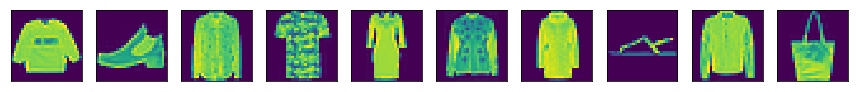

[['pullover'],
 ['ankle boot'],
 ['shirt'],
 ['t-shirt'],
 ['dress,'],
 ['coat'],
 ['coat'],
 ['sandal'],
 ['coat'],
 ['bag']]

In [5]:
DataLoader.show_images(train_img[0:10])
DataLoader.get_labels(train_labels[0:10])

In [6]:
train_img.shape

(60000, 784)

In [7]:
train_labels.shape

(60000,)

In [8]:
# 修改为float以便求导，除以255做归一化
train_img_nd = nd.array(train_img).astype(np.float32)/255
train_lab_nd = nd.array(train_labels).astype(np.float32)
test_img_nd = nd.array(test_img).astype(np.float32)/255
test_lab_nd = nd.array(test_labels).astype(np.float32)

In [9]:
def data_iter(batch_size=100, kind='train'):
    if kind != 'train':
        idx = list(range(len(test_labels)))
        for i in range(0,len(test_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(test_labels))])
            yield nd.take(test_img_nd,j), nd.take(test_lab_nd,j)
    else:
        idx = list(range(len(train_labels)))
        for i in range(0,len(train_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(train_labels))])
            yield nd.take(train_img_nd,j), nd.take(train_lab_nd,j)

# Model

$$\boldsymbol{\hat y} = net({\boldsymbol x}) = softmax({\boldsymbol{x}}\ {W} + {\boldsymbol{b}})$$

In [10]:
md_ctx = mx.gpu()
num_input = 784
num_output = 10
num_examples = len(train_labels)
batch_size = 100

W = nd.random_normal(shape=(num_input, num_output),ctx=md_ctx)
W.attach_grad()
b = nd.random_normal(shape=(num_output),ctx=md_ctx)
b.attach_grad()

params = [W,b]

In [11]:
def softmax(X):
    e = nd.exp(X)
    t = nd.sum(e, axis=1, keepdims=True)
    return e/t

In [12]:
def net(X):
    X = X.as_in_context(md_ctx)
    return softmax(nd.dot(X,W) + b)

In [13]:
def cross_entropy(yhat,y):
    yhat = yhat.as_in_context(md_ctx)
    y = y.as_in_context(md_ctx)
    return - nd.log(nd.pick(yhat,y))

# Train

In [14]:
def SGD(params, lr):
    for p in params:
        p[:] = p - lr*p.grad

In [15]:
# 新建一个“精度”计算的函数
def accuracy(yhat,y):
    yhat = yhat.as_in_context(md_ctx)
    y = y.as_in_context(md_ctx)
    return nd.mean(yhat.argmax(axis=1)==y).asscalar()

In [16]:
epochs = 5

t1 = datetime.datetime.now()

for e in range(epochs):
    train_loss = 0.
    train_accu = 0.
    
    for data,label in data_iter(batch_size=batch_size):
        with ag.record():
            yhat = net(data)
            loss = cross_entropy(yhat,label)
        loss.backward()
        SGD(params, 0.1/batch_size)
                
        train_loss += nd.mean(loss).asscalar()
        train_accu += accuracy(yhat,label)

    print(train_loss/len(train_labels))
    print(train_accu/len(train_labels))

print(datetime.datetime.now()-t1)

0.0251799697916
0.00568433331624
0.0139874141524
0.00699533334474
0.0117075779195
0.00735666667322
0.0104832933351
0.00754649999837
0.00968289639701
0.00767199999293
0:00:04.014128


# Test

In [17]:
yhat = net(test_img_nd)
accu = accuracy(yhat,test_lab_nd)

print(accu/len(test_labels))

7.72400021553e-05


In [18]:
# 分组查看各类图像的错误情况

test_pred = yhat.argmax(axis=1).asnumpy()
err = test_pred - test_labels
err_idx = err.nonzero()[0]
err_idx.shape

(2276,)

In [19]:
err_nums = nd.zeros(shape=(10,1))
err_detail = nd.zeros(shape=(10,10))

for i in err_idx:
    err_num = test_labels[i]
    err_nums[err_num.item()] += 1
    err_detail[err_num.item(),int(test_pred[i].item())] += 1

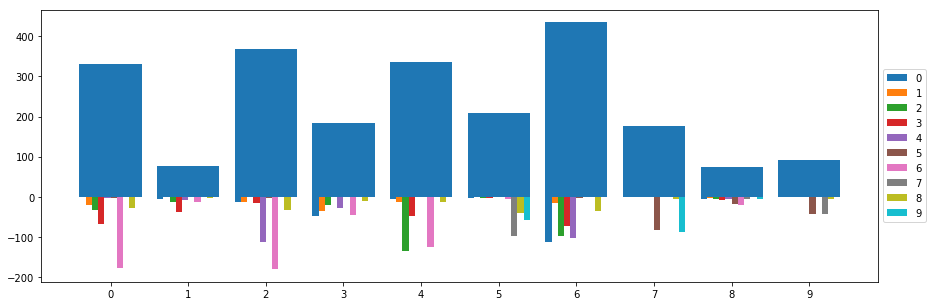

In [20]:
bar_width_rate = 0.08

plt.figure(figsize=(15,5)) 
plt.bar(np.arange(10),err_nums.asnumpy(),width=bar_width_rate*10)

for j in range(10):
    plt.bar(np.arange(10)-bar_width_rate*5+bar_width_rate/2+j*bar_width_rate,
            -err_detail.T[j].asnumpy(),
            label=j,
            width=bar_width_rate,
            color='C'+str(j))
plt.xticks(np.arange(10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
DataLoader.get_labels(test_labels[0:1])

[['t-shirt']]

true label: [['t-shirt']] Pred label: [['shirt']]
(177, 784)


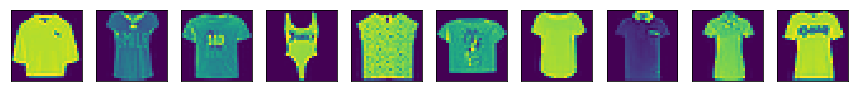

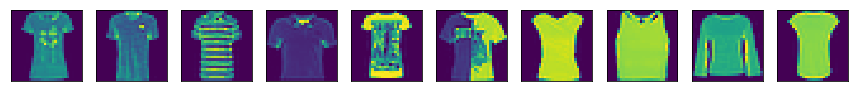

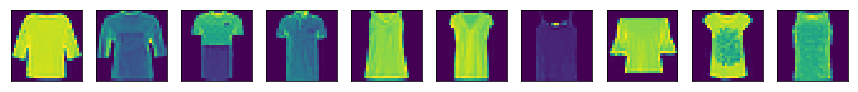

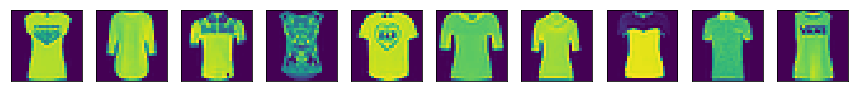

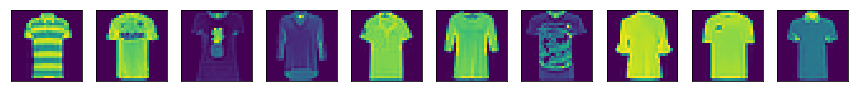

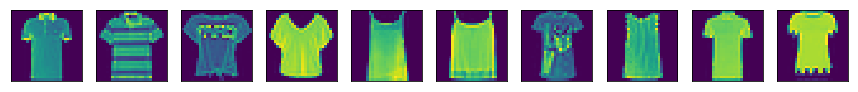

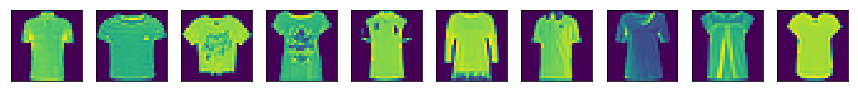

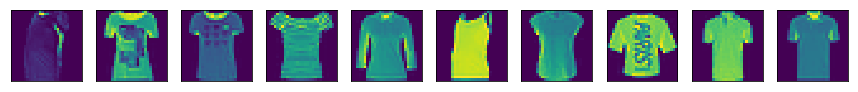

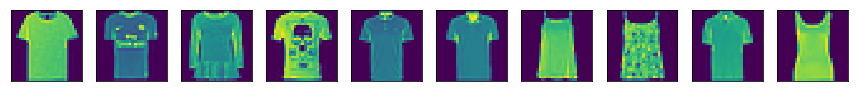

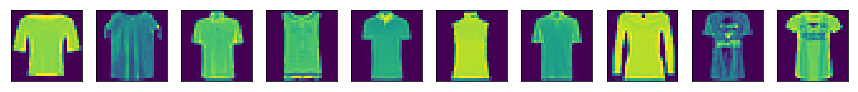

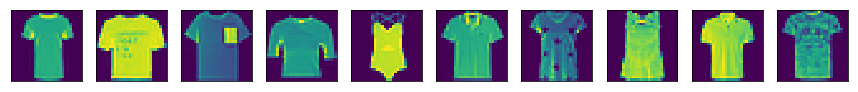

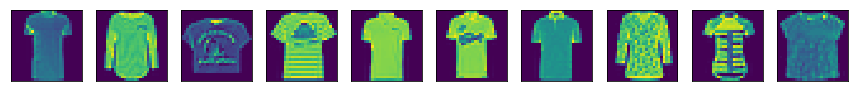

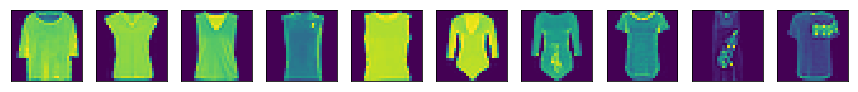

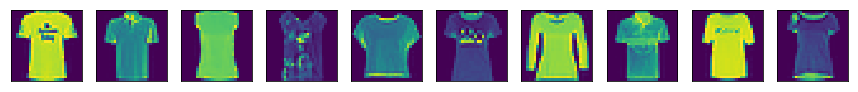

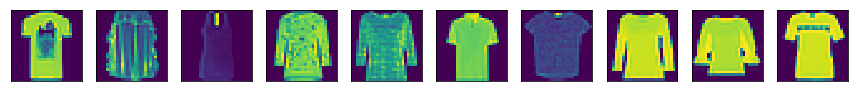

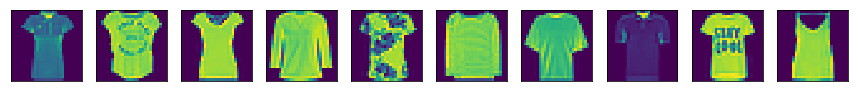

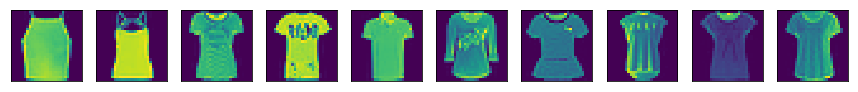

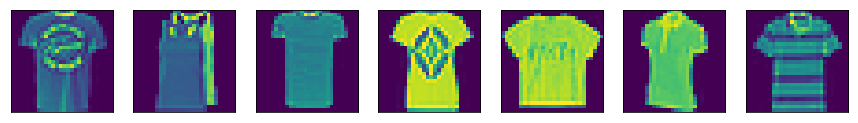

In [22]:
# 查看将0错认为6的图片

imgs = np.empty(shape=[0,28*28])
for i,tl,tp in zip(range(len(test_labels)),test_labels,test_pred):
    if (tl==0) and (tp == 6.):
        imgs = np.row_stack((imgs,test_img[i]))

print("true label:", DataLoader.get_labels([0]), "Pred label:", DataLoader.get_labels([6]))
print(imgs.shape)

for j in range(0,len(imgs),10):
    DataLoader.show_images(imgs[j:min(j+10,len(imgs))])